#Part 4. Changing the tune through the NLL magnet - Influence on the Invariants

This is part 4 in the notebook series investigating how the single particle invariants change with increase particle amplitude (or bunch generalized emittance). See [Part 1 - Comparing Full Chef to Linear Dynamics](IOTA6-6 - Testing Larger Amplitude Particles with the Nonlinear Element - PT1 - Comparing Full chef to linear dynamics.ipynb) for a look at how the nonlinear aspects of "linear" lattice elements may affect the invariant. See [Part 2 -  Slicing the Nonlinear Magnet in MADX](IOTA6-6 - Testing Larger Amplitude Particles with the Nonlinear Element - PT 2 - Increasing the magnet slices.ipynb) for a look at how further refinement/slicing of the nonlinear magnet can influence the particle motion. See [Part 3 - Changing the Tune](IOTA6-6 - Testing Larger Amplitude Particles with the Nonlinear Element - PT 3 - Changing the tune through the NLL magnet.ipynb) to see how increasing the tune through the NLL element increases the spread in the invariant for a test particle.

The testing in part 1 showed a strong reduction in the number of outliers from our bunch (those particles with extremely large deviations from the mean invariant over the 100 turns). The result was a significant reduction in the standard deviation of the 2nd invariant - from ~16% down to 3% - and an additional reduction in the Hamiltonian (1st invariant) - from 3.1% down to 2.4%. 

The testing in part 2 made clear that the nonlinear potential is well described using 20 total slices. Increasing the number of slices to 40 made very little difference in the statistical spread of the single particle invariants, as the mean values remained the same, and standard deviations of 2.4% in H and 3.1% in I remained.

The basis for the testing in part 3 was the notion that the nonlinear Hamiltonian specified by the IOTA lattice is not fully integrable, and that higher order terms from the complete transfer map through the potential have $O(\nu^3)$ dependence on the tune through the NLL magnets. I constructed a new NLL magnet section with 2x the tune and derived an R-matrix to complete the new toy lattice. Basic simulations with a single particle showed an increase in the standard deviations, to 8.4% in H, and 11.6% in I.


####Execution
**For this notebook, we will still consider a NL element with larger tune.** Using the same R-matrix and element from the previous notebook, I will construct an appropriately matched bunch with generalized emittance of approximately 10 mm-mrad, and I will run with for ~100 turns with 1000 macro particles.

The adjusted nonlinear element has twice the length and twice the phase advance. I still constructed it with 40 slices, to maintain similar resolution to the original (20 slices per 1.8 m). It is stored in the file `nll_40slices_0pt6_tune.madx`.

In [1]:
%load_ext watermark
%load_ext autoreload
%autoreload 2

In [2]:
%watermark -d -v -a "Nathan Cook"

Nathan Cook 18/08/2015 

CPython 2.7.10
IPython 3.1.0


In [3]:
import sys, os
import synergia
from mpi4py import MPI
import synergia_workflow

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from elliptic import EllipticBeam6D
from base_diagnostics import lfplot

In [33]:
lattice = synergia.lattice.MadX_reader().get_lattice("base_nll", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/nll_40slices_0pt6_tune.madx")
#lattice2 = synergia.lattice.MadX_reader().get_lattice("iota", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/lattice_1IO_center.madx")


for elem in lattice.get_elements():
    if elem.get_type() == 'nllens':
        elem.set_string_attribute("extractor_type", "chef_propagate")

nsteps_per_element = 10
nsteps = len(lattice.get_elements())*nsteps_per_element
        
name = 'Double-tune-NLL-matched-flipped'
order = 1
outputdir = 'order_'+str(order)+'_'+name

opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
opts.macro_particles=1000
#opts.emitx = 1.0e-5
workflow.make_path(outputdir)


stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

#stepper2 = synergia.simulation.Independent_stepper_elements(lattice2, opts.map_order, opts.steps_per_element)
#lattice_simulator2 = stepper2.get_lattice_simulator()

In [5]:
def get_base_nll(nn, l0, mu0, t, c):
    '''Construct the nonlinear element. Taken from madx script by A. Valishev.
    
    '''
    #musect=mu0+0.5;
    f0=l0/4.0*(1.0+1.0/np.tan(np.pi*mu0)**2); #focal length
    betae=l0/np.sqrt(1.0-(1.0-l0/2.0/f0)**2); #entrance beta function
    alphae=l0/2.0/f0/np.sqrt(1.0-(1.0-l0/2.0/f0)**2); #entrance alpha function
    betas=l0*(1-l0/4.0/f0)/np.sqrt(1.0-(1.0-l0/2.0/f0)**2); #middle beta function
    #value,f0,betae,alfae,betas;
    
    return [f0, betae,alphae,betas]

In [6]:
new_tune = 0.6
lnll = 3.6
nseg = 40
t = 0.4
c = 0.01
vals = get_base_nll(nseg, lnll, new_tune, t, c)
print vals

[0.99501552810007565, 6.1246858201346921, 3.0776835371752562, 0.58485545321923105]


In [7]:
from base_diagnostics import latticework
fnew = vals[0]
toy_R = latticework.make_R(fnew)
print toy_R[0:2,0:2]
print toy_R[2:4,2:4]
print toy_R[4:6,4:6]

[[ 1.          0.        ]
 [-1.00500944  1.        ]]
[[ 1.          0.        ]
 [-1.00500944  1.        ]]
[[ 1.   3.2]
 [ 0.   1. ]]


###Construct the turn_end_action operator

In [34]:
class Pickle_helper:
    __getstate_manages_dict__ = 1
    def __init__(self, *args):
        self.args = args
    def __getinitargs__(self):
        return self.args
    def __getstate__(self):
        return self.__dict__
    def __setstate__(self, state):
        self.__dict__ = state

class turn_actions(synergia.simulation.Propagate_actions, Pickle_helper):
    def __init__(self, mat):
        synergia.simulation.Propagate_actions.__init__(self)
        Pickle_helper.__init__(self, mat)
        self.matrix = mat #R-matrix being imported
    def turn_end_action(self, stepper, bunch, turn_num):
        '''Move particles through a single drift and advance the reference particle by the drift length'''
        
        #define matrix
        R_matrix = self.matrix
        
        particles = bunch.get_local_particles();
        for particle in particles:
            new_particle = np.dot(R_matrix,particle[0:6]) #This is for full 6x6 multiplication, not using currently.
            
            #just perform x+y-plane updates
            #new_particle = np.zeros(6)
            #new_particle[0:2] = np.dot(R_matrix[0:2,0:2],particle[0:2])
            #new_particle[2:4] = np.dot(R_matrix[2:4,2:4],particle[2:4])
            particle[0:6] = new_particle

#construct the operator using our toy R matrix
turn_action = turn_actions(toy_R)

###Construct a matched bunch

Recall we are matching at the start of the NLL magnet.

In [31]:
opts.emit_transverse = 1.e-5
EllipticBeam6D.EllipticalBeam6D(opts)

ref = lattice.get_reference_particle()
#read in the file and construct a synergia bunch
particles_file = 'myBunch.txt'
comm = synergia.utils.Commxx(True)
bucket_length = 0.05 #workaround
myBunch = read_bunch.read_bunch(particles_file, ref, opts.real_particles, bucket_length, comm, verbose=False)

original_particles = np.copy(myBunch.get_local_particles()) #make a copy of the original particles

 !Warning -- 
File myBunch.txt already exists. Renaming the old file to myBunch.txt1439882570
Loading Synergia particles from txt file:  myBunch.txt


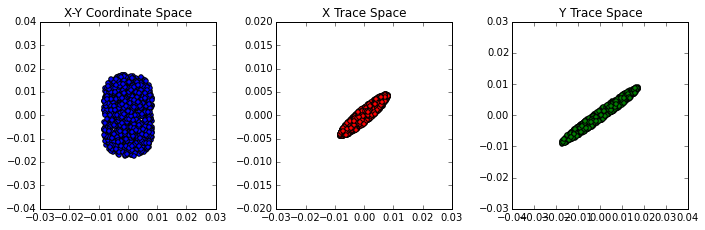

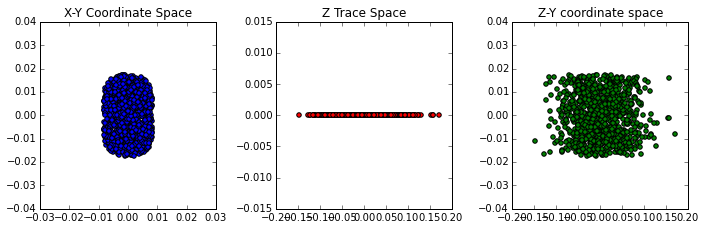

In [32]:
from base_diagnostics import pltbunch
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [35]:
# Define a bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

# Define a set of bunch diagnostics

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
diagnostics = synergia.bunch.Diagnostics_track("track.h5", opts.tracked_particles, opts.output_dir)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_step(diagnostics)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag)

In [36]:
opts.turns = 100
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator, turn_action,
                     opts.turns, opts.maxturns,opts.verbosity)

#clean up files
workflow.cleanup(opts.output_dir)

###Diagnostics - Left Tilted Bunch (negative alpha)

/Users/ncook/.virtualenvs/synergiaenv/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


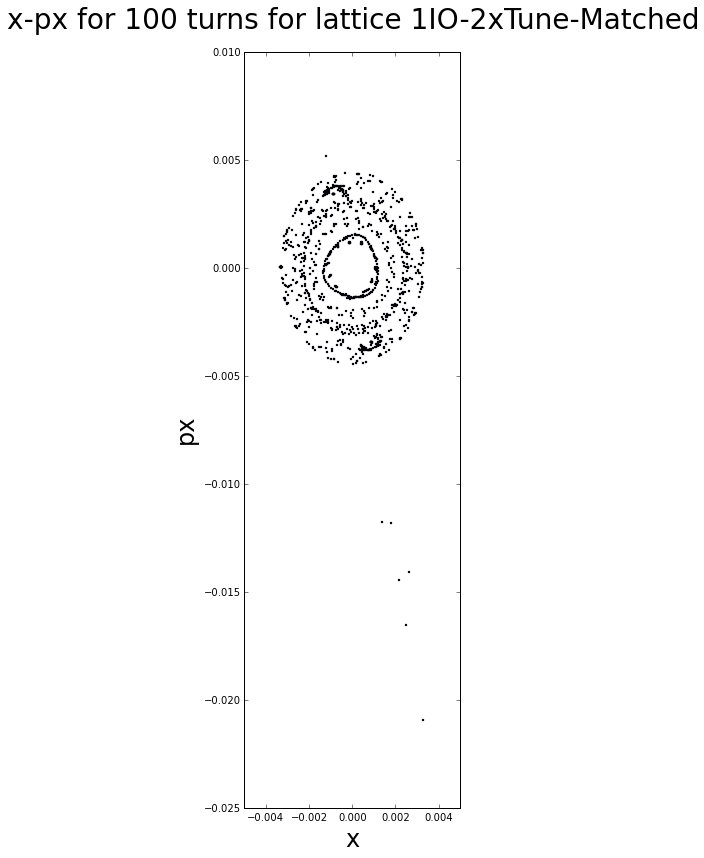

In [19]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-2xTune-Matched'
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice

popts.plots = ['x','px']
popts.num = 10
popts.scale = 2
popts.plot_lost = False

singleparticle.toy_plot_Poincare(popts, vals)

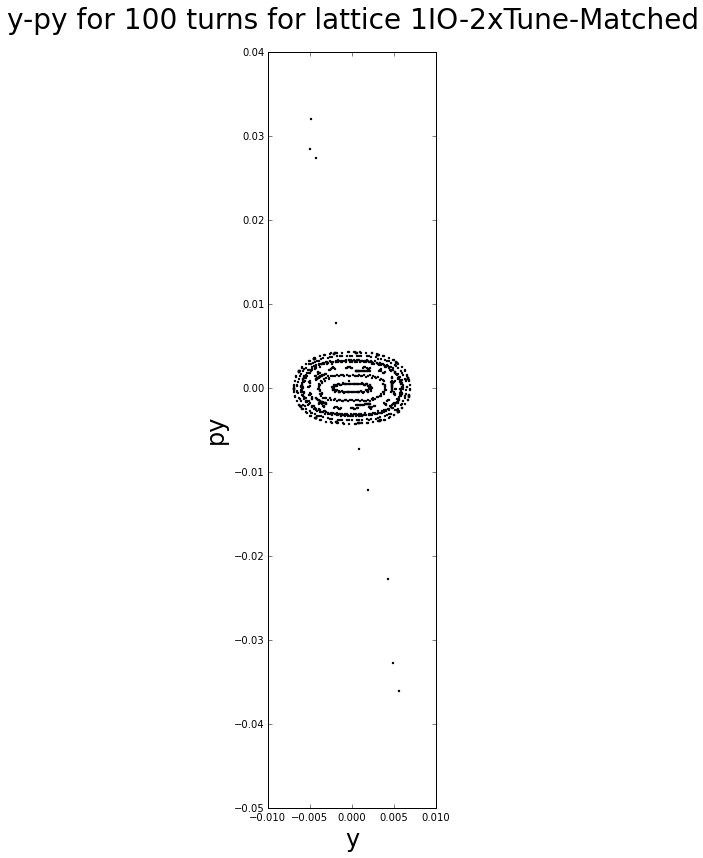

In [20]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-2xTune-Matched'
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice

popts.plots = ['y','py']
popts.num = 10
popts.scale = 2
popts.plot_lost = False

singleparticle.toy_plot_Poincare(popts, vals)

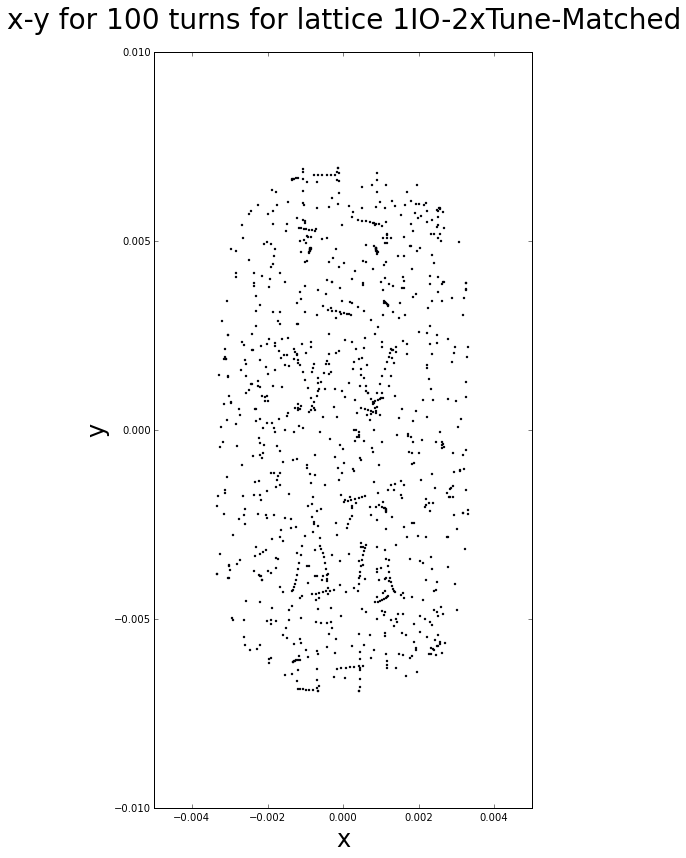

In [21]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-2xTune-Matched'
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice

popts.plots = ['x','y']
popts.num = 10
popts.scale = 2
popts.plot_lost = False

singleparticle.toy_plot_Poincare(popts, vals)

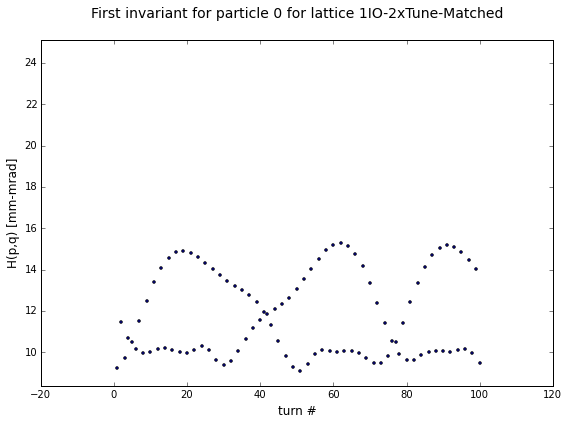

In [26]:
#popts.lattice_simulator = stepper.get_lattice_simulator()
popts.num = 1
popts.ID = 0
popts.variance = .5
popts.save = False
singleparticle.toy_plot_elliptic_Invariant(popts, vals)
#singleparticle.plot_H_I(popts)

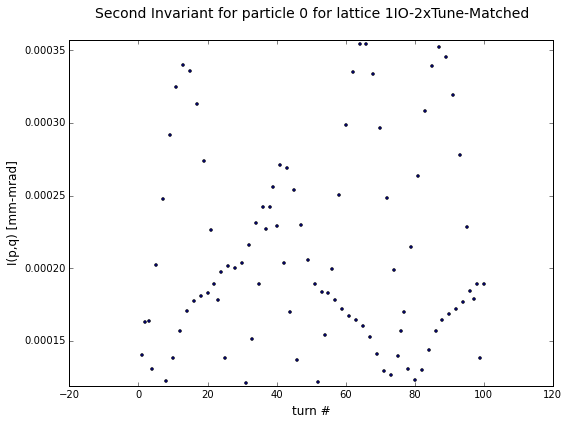

In [27]:
#popts.lattice_simulator = stepper.get_lattice_simulator()
popts.num = 2
popts.ID = 0
popts.variance = .5
popts.save = False
singleparticle.toy_plot_elliptic_Invariant(popts, vals)
#singleparticle.plot_H_I(popts)

In [30]:
popts.macro_particles = opts.macro_particles
hArray = singleparticle.toy_calc_elliptic_Invariant(popts, vals)
singleparticle.stats_Invariant(hArray,popts)

H -  Mean: 16.7426406736 [mm-mrad] std (%): 300.26505773
I -  Mean: 0.000238072700994 [mm-mrad] std (%): 143.904669822


In [16]:
vals

[0.99501552810007565,
 6.1246858201346921,
 3.0776835371752562,
 0.58485545321923105]

###Diagnostics - Right Tilted Bunch (positive alpha in matching script)

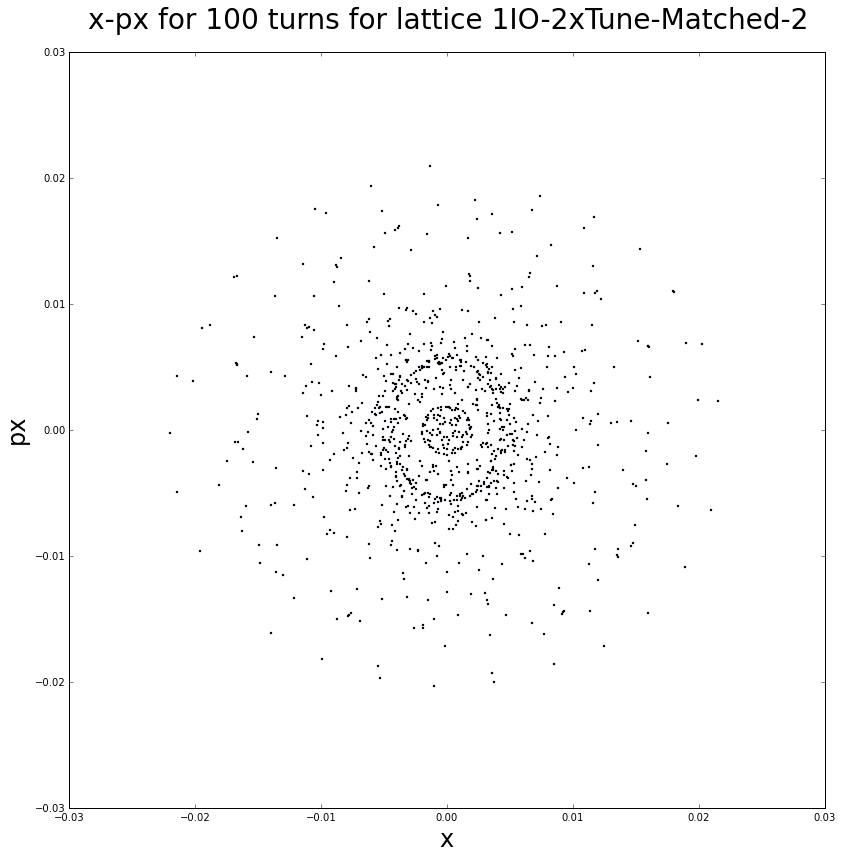

In [37]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-2xTune-Matched-2'
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice

popts.plots = ['x','px']
popts.num = 10
popts.scale = 2
popts.plot_lost = False

singleparticle.toy_plot_Poincare(popts, vals)

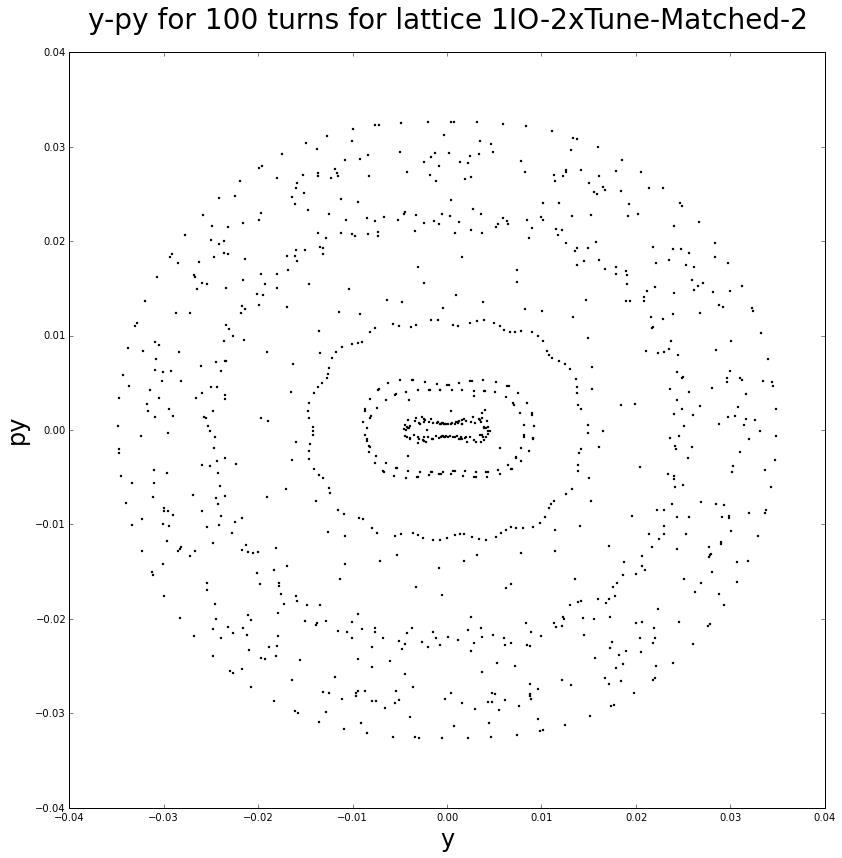

In [38]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-2xTune-Matched-2'
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice

popts.plots = ['y','py']
popts.num = 10
popts.scale = 2
popts.plot_lost = False

singleparticle.toy_plot_Poincare(popts, vals)

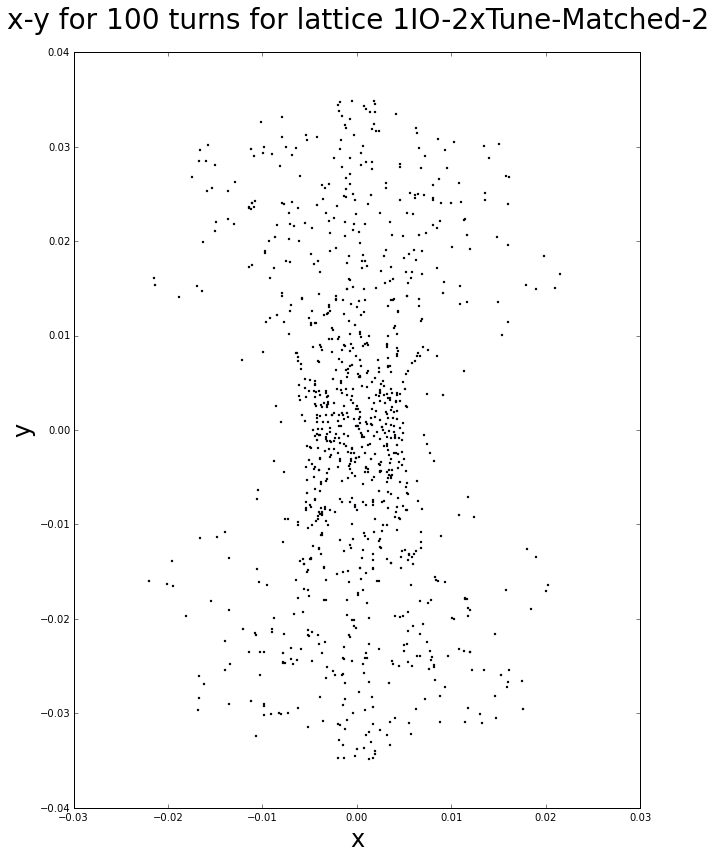

In [39]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-2xTune-Matched-2'
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice

popts.plots = ['x','y']
popts.num = 10
popts.scale = 2
popts.plot_lost = False

singleparticle.toy_plot_Poincare(popts, vals)

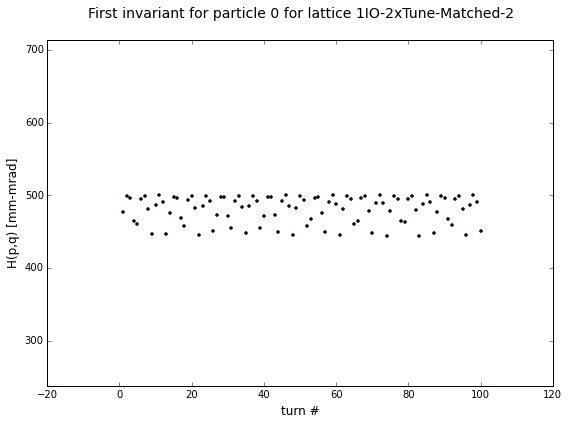

In [59]:
#popts.lattice_simulator = stepper.get_lattice_simulator()
popts.num = 1
popts.ID = 0
popts.variance = .5
popts.save = False
singleparticle.toy_plot_elliptic_Invariant(popts, vals)
#singleparticle.plot_H_I(popts)

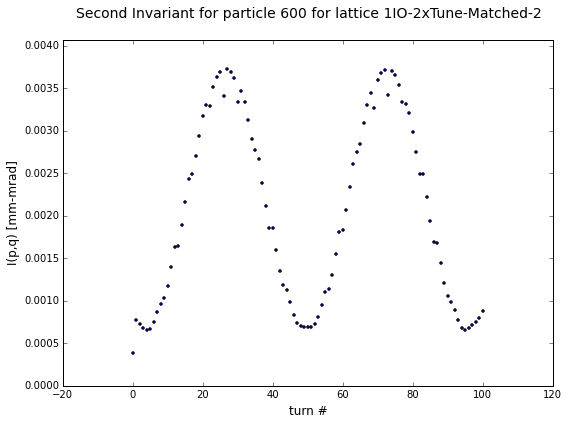

In [64]:
#popts.lattice_simulator = stepper.get_lattice_simulator()
popts.num = 2
popts.ID = 600
popts.variance = 1
popts.save = False
singleparticle.toy_plot_elliptic_Invariant(popts, vals)
#singleparticle.plot_H_I(popts)

In [70]:
popts.macro_particles = opts.macro_particles
hArray = singleparticle.toy_calc_elliptic_Invariant(popts, vals)
singleparticle.stats_Invariant(hArray,popts)

H -  Mean: 415.618047222 [mm-mrad] std (%): 10.6039003704
I -  Mean: 0.00203455547857 [mm-mrad] std (%): 53.8535169899


The Hamiltonian deviation is in line with expectations, while the 2nd invariant is not nearly as well behaved. This is probably to be expected, and for large tune shifts it may be difficult to properly quantify its variance.